In [ ]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Siteck_ML\Pepper_Price_Analysis\notebooks\2_Features_Engineering.ipynb

---
### *<BR> Importing needed libraries*

In [278]:

from sklearn.metrics import (
    root_mean_squared_error,r2_score
)

from sklearn.ensemble import (
    RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
)

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBRFRegressor

from sklearn.linear_model import (
    LinearRegression,ElasticNet
)

from sklearn.model_selection import (
    TimeSeriesSplit
)

from sklearn.preprocessing import (
        LabelEncoder,StandardScaler,PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
        )

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from tqdm import tqdm

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials
from tqdm import tqdm

In [279]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor(),
                "SVR":SVR(),
                "ElasticNet":ElasticNet(),
                "LinearRegression":LinearRegression()
}

In [280]:
def evaluation_preds(y_true,predicted):
    RMSE=root_mean_squared_error(y_true,predicted)
    return RMSE

In [282]:
def define_x_y(data):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    test_data=data[-20:]
    time_series_data = test_data.values
    for train_index, test_index in tscv.split(time_series_data):
        x_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
        x_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]
        models_list=[]
        RMSE_list=[]
        for i in  range(len(list(models))):
            model=list(models.values())[i]
            model.fit(x_train,y_train)

            train_predicted=model.predict(x_train)
            test_predicted=model.predict(x_test)      
            
            test_predicted_RMSE=evaluation_preds(y_test,test_predicted)
            
            RMSE_list.append(test_predicted_RMSE)

            models_list.append(list(models.keys())[i])
            
    report=pd.DataFrame(list(zip(models_list,RMSE_list)),columns=["model","RMSE"]).sort_values(by="RMSE",ascending=True)
    return report

In [290]:
def best_model(data,model):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    test_data=data[-20:]
    time_series_data = test_data.values
    for train_index, test_index in tscv.split(time_series_data):
        x_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
        x_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]
        clf=model()
        clf.fit(x_train,y_train)
        predicted=clf.predict(x_test)
        new_date_index=pd.date_range(start="2023-10-01",end="2023-10-22",freq="W")
        outcome=pd.concat([pd.DataFrame(new_date_index,columns=["date"]),pd.DataFrame(predicted,columns=["price"])],axis=1)
        outcome.set_index("date",inplace=True)
    return outcome

In [283]:
np.random.seed(42)
df_green_eval=define_x_y(df_green)
df_green_eval

,model,RMSE
3,GradientBoostingRegressor,0.064642
2,XGBRFRegressor,0.080160
0,RandomForestRegressor,0.099214
5,SVR,0.148727
4,AdaBoostRegressor,0.165842
1,DecisionTreeRegressor,0.194884
6,ElasticNet,0.599386
7,LinearRegression,0.645050


In [291]:
df_green_best_pred=best_model(df_green,GradientBoostingRegressor)
df_green_best_pred

,price
date,
2023-10-01,6.582972
2023-10-08,6.645958
2023-10-15,6.929250
2023-10-22,6.896288


In [285]:
np.random.seed(42)
df_red_eval=define_x_y(df_red)
df_red_eval

,model,RMSE
3,GradientBoostingRegressor,0.210033
2,XGBRFRegressor,0.253943
1,DecisionTreeRegressor,0.273900
0,RandomForestRegressor,0.285234
4,AdaBoostRegressor,0.291887
5,SVR,0.387139
6,ElasticNet,0.806314
7,LinearRegression,0.821034


In [286]:
df_red_best_pred=best_model(df_red,GradientBoostingRegressor)
df_red_best_pred

,price
date,
2023-10-01,7.011525
2023-10-08,7.083081
2023-10-15,7.212597
2023-10-22,7.315812


In [287]:
np.random.seed(42)
df_yellow_eval=define_x_y(df_yellow)
df_yellow_eval

,model,RMSE
2,XGBRFRegressor,0.390824
3,GradientBoostingRegressor,0.430872
4,AdaBoostRegressor,0.451156
1,DecisionTreeRegressor,0.653305
0,RandomForestRegressor,0.807595
5,SVR,0.875853
6,ElasticNet,1.011310
7,LinearRegression,2.163458


In [288]:
df_yellow_best_pred=best_model(df_yellow,XGBRFRegressor)
df_yellow_best_pred

,price
date,
2023-10-01,8.967743
2023-10-08,8.200655
2023-10-15,8.762077
2023-10-22,8.315688


Text(0.5, 1.0, 'df_red_evaluation')

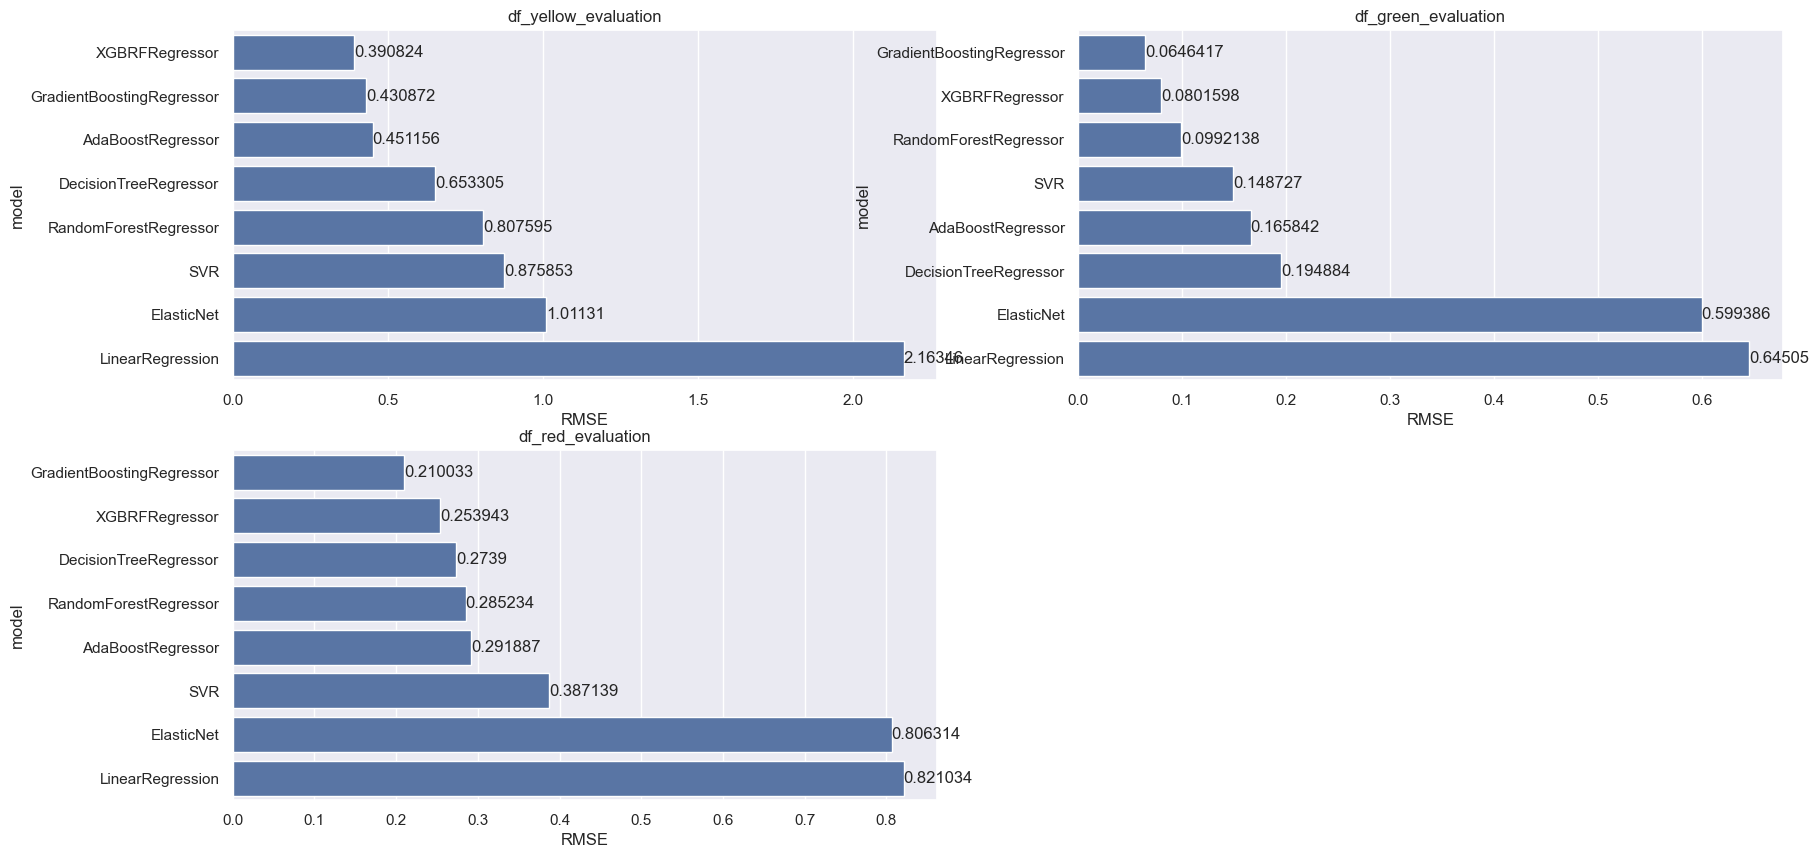

In [289]:
plt.subplot(221)
ax=sns.barplot(data=df_yellow_eval,y="model",x="RMSE")
for i in ax.containers:
    ax.bar_label(i,)
plt.title("df_yellow_evaluation")   
plt.subplot(222)
ax=sns.barplot(data=df_green_eval,y="model",x="RMSE")
for i in ax.containers:
    ax.bar_label(i,)
plt.title("df_green_evaluation")    
plt.subplot(223)
ax=sns.barplot(data=df_red_eval,y="model",x="RMSE")
for i in ax.containers:
    ax.bar_label(i,)    
plt.title("df_red_evaluation")              